In [1]:
from dtw import * ;  import numpy as np ; from scipy.io.wavfile import read ; import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean ;  from fastdtw import fastdtw ;  import sounddevice as sd
from os.path import dirname, join as pjoin ;  from scipy.io import wavfile ; import scipy.io; import os
import glob ; import webrtcvad;import statistics;from dtwalign import dtw as dtwalign ;import contextlib ; 
import collections ; import contextlib;import sys;import wave

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Speech Indicator

### Returns time stamp, query, and percentage of speaking duration (w/o first and last pause)

In "The diagnostic utility of patient-report and speech- language pathologists’ ratings for detecting the early onset of bulbar symptoms due to ALS", pauses are defined as longer than 300 ms.


Using 20-40ms as frame length for speech analysis: https://www.researchgate.net/publication/224217613_Preference_for_20-40_ms_window_duration_in_speech_analysis

In [3]:
window_len = 30 # Unit: ms

capstone_dir = "/Users/ninismacbook/other_docs/Y4S1/capstone"


def speech(filename):
    
    filepath = capstone_dir + "/downsampled/" + filename

    samplerate, query = wavfile.read(filepath)
    
    abs_q = np.abs(query)
    
    # The range in which we pick the upper and lower bound for voice
    range1 = range(0, int(samplerate*0.1))
    
    
    length = query.shape[0] / samplerate
    time = np.linspace(0., length, query.shape[0])
    
    # Find max and min of the first second to be upper and lower bound of filter
    upper = np.max(query[range1]) ; lower = np.min(query[range1])    
    
    frame_per_window = samplerate * window_len/1000
    
    # Convert all data in the query to absolute values
    plot_q = np.abs(query)
    
    # Rolling average of the window
    for i in range(len(plot_q)):
        if i < frame_per_window/2:
            i1 = 0 ; i2 = i + int(frame_per_window/2)            
        elif i > (len(plot_q) - frame_per_window/2):
            i1 = i - frame_per_window/2 ; i2 = len(query)
        else:
            i1 = i-frame_per_window/2 ; i2 = i+frame_per_window/2
        
        plot_q[i] = np.mean(plot_q[int(i1) : int(i2)])
    
    for i in range(len(plot_q)):
        if plot_q[i] > lower and plot_q[i] < upper:
            plot_q[i] = 0
            plot_q[i] = 0
        else:
            plot_q[i] = 1
    
    # Remove the first and last pause when calculating speak rate
    new_q = plot_q.copy()
    new_q = new_q[np.where(new_q == 1)[0][0] : len(new_q)]
    last_speak = np.where(new_q == 1)[0][len(np.where(new_q == 1)[0])-1]

    # Note: plot_q is for plotting. new_q is the query whose first and last pause are eliminated
    # Use new_q to calculate speech vs non speech percentage
          
    return time, plot_q, sum(new_q)/len(new_q)*100, samplerate



Overall speaking rate (percentage) :  73.2117237138758


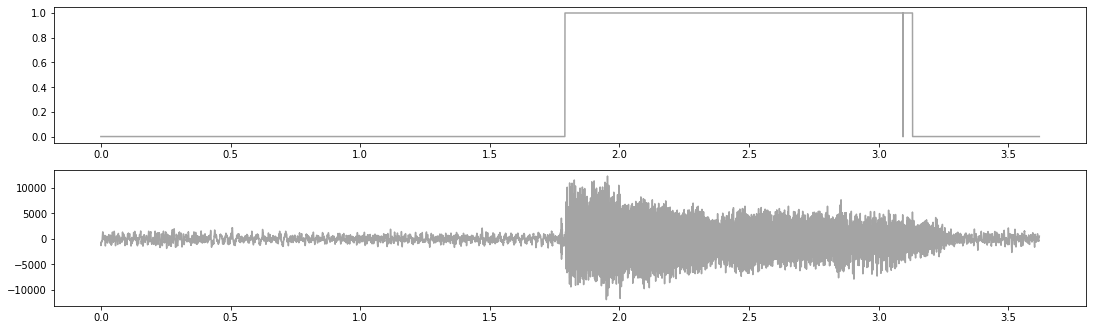

In [5]:
# should be around 41%. At 00:01.77 - 00:03.26 I said Ahhhh

file = 'test_vad01.wav'
print('Overall speaking rate (percentage) : ', speech(file)[2])

fig, (ax1, ax2) = plt.subplots(2, 1); fig.set_size_inches(18.5, 5.5)

ax1.plot(speech(file)[0], speech(file)[1], color = '#A4A4A4')

samplerate, query = wavfile.read(capstone_dir + '/downsampled/' + file) 
length = query.shape[0] / samplerate ; time = np.linspace(0., length, query.shape[0])

ax2.plot(time, query, color = '#A4A4A4');

In [7]:
print(query.shape[0])

28952


Overall speaking rate (percentage) :  26.443897291593387


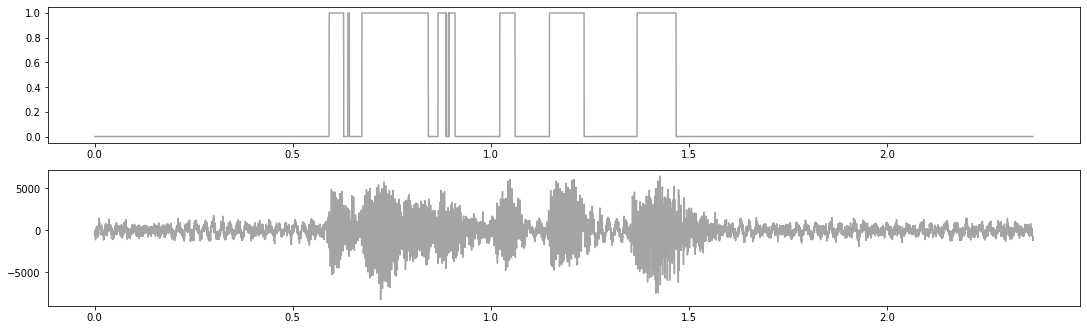

In [13]:
file = 'test_vad02.wav'
print('Overall speaking rate (percentage) : ', speech(file)[2])
fig, (ax1, ax2) = plt.subplots(2, 1); fig.set_size_inches(18.5, 5.5)

ax1.plot(speech(file)[0], speech(file)[1], color = '#A4A4A4')


samplerate, query = wavfile.read(capstone_dir + '/downsampled/' + file) 
length = query.shape[0] / samplerate ; time = np.linspace(0., length, query.shape[0])

ax2.plot(time, query, color = '#A4A4A4');

Overall speaking rate (percentage) :  22.799855008871166


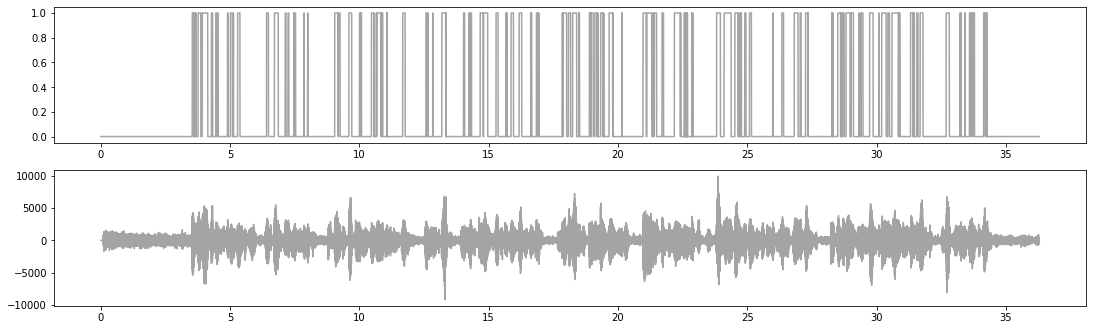

In [14]:
file = '01.wav'
print('Overall speaking rate (percentage) : ', speech(file)[2])
fig, (ax1, ax2) = plt.subplots(2, 1); fig.set_size_inches(18.5, 5.5)

ax1.plot(speech(file)[0], speech(file)[1], color = '#A4A4A4')

samplerate, query = wavfile.read(capstone_dir + '/downsampled/' + file) 
length = query.shape[0] / samplerate ; time = np.linspace(0., length, query.shape[0])

ax2.plot(time, query, color = '#A4A4A4');

Overall speaking rate (percentage) :  32.53919644390002


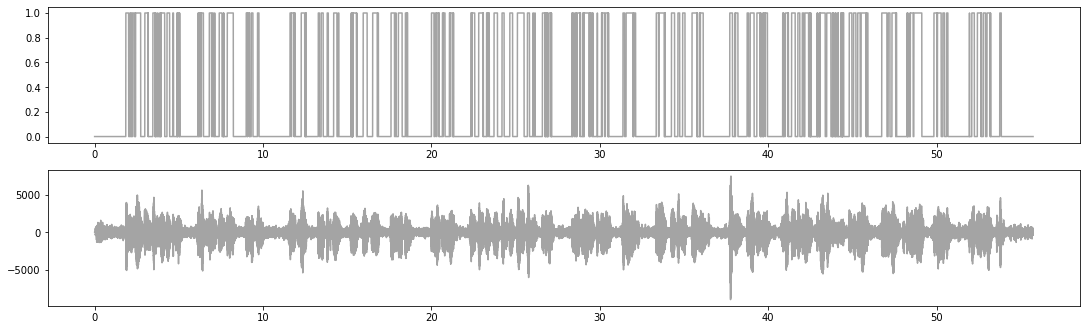

In [15]:
file = '02.wav'
print('Overall speaking rate (percentage) : ', speech(file)[2])
fig, (ax1, ax2) = plt.subplots(2, 1); fig.set_size_inches(18.5, 5.5)

ax1.plot(speech(file)[0], speech(file)[1], color = '#A4A4A4')

samplerate, query = wavfile.read(capstone_dir + '/downsampled/' + file) 
length = query.shape[0] / samplerate ; time = np.linspace(0., length, query.shape[0])

ax2.plot(time, query, color = '#A4A4A4');

Overall speaking rate (percentage) :  28.555673272313598


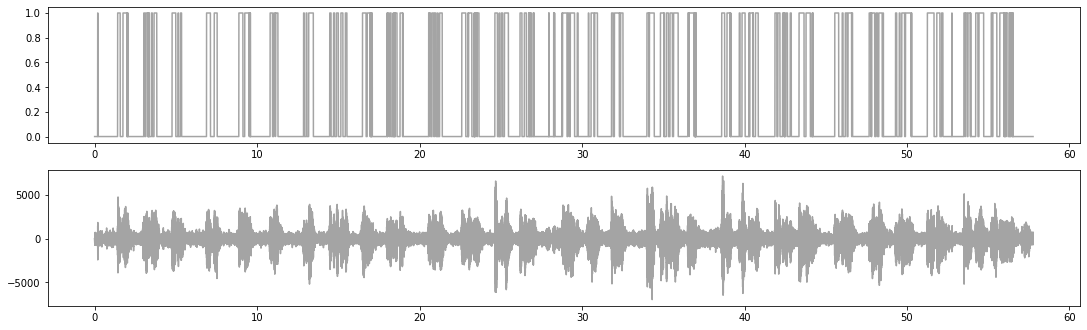

In [16]:
file = '05.wav'
print('Overall speaking rate (percentage) : ', speech(file)[2])
fig, (ax1, ax2) = plt.subplots(2, 1); fig.set_size_inches(18.5, 5.5)

ax1.plot(speech(file)[0], speech(file)[1], color = '#A4A4A4')
samplerate, query = wavfile.read(capstone_dir + '/downsampled/' + file) 
length = query.shape[0] / samplerate ; time = np.linspace(0., length, query.shape[0])

ax2.plot(time, query, color = '#A4A4A4');

# Pause Indicator

### Returns time stamp, query, and percentage of pause duration (w/o first and last pause)

In [24]:
def pause(filename):
    filepath = capstone_dir + "/py_converted/" + filename
    
    time = speech(file)[0]
    plot_q = speech(file)[1]
    plot_q = [not elem for elem in plot_q]
    samplerate = speech(file)[3]
    
    return time, plot_q, 100-speech(file)[2], samplerate

In [25]:
file = 'test_vad02.wav'
print('Overall pause rate (percentage) : ', pause(file)[2])

Overall pause rate (percentage) :  73.55610270840661
